# PitchShiftNN Training
This is the notebook used to train the Vocal Pitch Modulator.

## Global variables/Imports
Run these cells before running either of the following sections.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport PitchShiftNN
from PitchShiftNN import *

In [2]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

## Constants

In [3]:
# Percentage of overlap amongst STFT windows

overlap = 0.75

## Data Generation
The methodology is explained in `Data Processing for Training PitchShiftNN.ipynb`.

In [4]:
# e.g. data_list[vowel_to_label["dog"]][5][1]
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                                     n_pitches, n_vowels, n_people)

# e.g. flat_data_ref_list[flat_ref_idx(3, 1, 2)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)

# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

In [5]:
data_label_pairs, data_label_pairs_dict = create_data_label_pairs(n_pitches)

all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, plot=False, overlap=overlap) for waveform in all_wav_data ])

In [6]:
def create_training_dataset(shift_amt, sparsity_factor = 8):
    """ 
    Creates X_train, X_val, Y_train, Y_val, list_of_test_idx for a single shift constant.

    Requires data_label_pairs_dict, all_wav_data, and all_spectrograms to be first created outside this method.

    Parameters: 
    shift_amt (int): -15 <= x <= 15
    sparsity_factor (int): number of windows to skip per spectrogram (to save memory)
                            only the training dataset is affected, the testing dataset is not affected

    Returns: 
    ndarray: X_train
    ndarray: Y_train
    ndarray: X_val
    ndarray: Y_val
    ndarray: list_of_test_idx
        each element is (flat idx of original, flat idx of original + shift_amt)
    """
    
    print('Creating dataset for shift_amt = {}'.format(shift_amt))
    
    # Initialize shift_amt dependent data structures
    
    pairs = data_label_pairs_dict[shift_amt]
    _, all_pitched_spectra = resample_pitch_shift(all_wav_data, shift_amt, overlap, n_ffts=1024)

    # X_train, Y_train: (_,1026 = 513*2), (_,513)
    # X_val, Y_val:     (_,1026 = 513*2), (_,513)

    X_train = []; X_val = []; Y_train = []; Y_val = [];
    list_of_test_idx = []

    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):

            # If the pair is valid (does not go out of range), then proceed.
            if [shift_amt, pit_idx, pit_idx + shift_amt] in pairs:

                # Choose the person for this pitch/vowel to be used as test data.
                test_pid = int(np.random.rand() * 3)

                for pid_idx in range(n_people):
                    wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                    wav_idx_shifted = flat_ref_idx(vow_idx, pit_idx + shift_amt, pid_idx)

                    if (pid_idx != test_pid):
                        x_item = np.hstack((all_spectrograms[wav_idx].T, all_pitched_spectra[wav_idx].T))[0::sparsity_factor]
                        y_item = all_spectrograms[wav_idx_shifted].T[0::sparsity_factor]
                        
                        X_train.extend(x_item)
                        Y_train.extend(y_item)
                    else:
                        x_item = np.hstack((all_spectrograms[wav_idx].T, all_pitched_spectra[wav_idx].T))
                        y_item = all_spectrograms[wav_idx_shifted].T
                        
                        X_val.extend(x_item)
                        Y_val.extend(y_item)
                        list_of_test_idx.append((wav_idx,wav_idx_shifted))

    X_train = np.array(X_train); Y_train = np.array(Y_train);
    X_val = np.array(X_val); Y_val = np.array(Y_val);
    list_of_test_idx = np.array(list_of_test_idx)

    # Datasets ignore phase information

    X_train = np.absolute(X_train)
    X_val = np.absolute(X_val)
    Y_train = np.absolute(Y_train)
    Y_val = np.absolute(Y_val)
    
    return X_train, Y_train, X_val, Y_val, list_of_test_idx

## Dataset Options

Please run the cells for **ONLY ONE** of the dataset options.

### Option 1: Set `shift_amt` to a constant

Please set `sparsity_factor = 1` because for a single shift amount, there is not much data.

In [7]:
X_train_prenorm, Y_train_prenorm, X_val_prenorm, Y_val_prenorm, list_of_test_idx = create_training_dataset(0, sparsity_factor=1)

print(X_train_prenorm.shape)
print(Y_train_prenorm.shape)
print(X_val_prenorm.shape)
print(Y_val_prenorm.shape)
print(list_of_test_idx.shape)

Creating dataset for shift_amt = 0
(44160, 1026)
(44160, 513)
(22080, 1026)
(22080, 513)
(192, 2)


### Option 2: Use `shift_amt` for all `-15 <= x <= 15`

In [7]:
X_train_prenorm = []; Y_train_prenorm = []; X_val_prenorm = []; Y_val_prenorm = []; list_of_test_idx = [];

for i in range(-9+1,9,1):
    _Xt, _Yt, _Xv, _Yv, _loti = create_training_dataset(i)
    X_train_prenorm.extend(_Xt)
    Y_train_prenorm.extend(_Yt)
    X_val_prenorm.extend(_Xv[:1]) # faked
    Y_val_prenorm.extend(_Yv[:1]) # faked
    list_of_test_idx.extend(_loti)
    
X_train_prenorm = np.array(X_train_prenorm)
Y_train_prenorm = np.array(Y_train_prenorm)
X_val_prenorm = np.array(X_val_prenorm)
Y_val_prenorm = np.array(Y_val_prenorm)
list_of_test_idx = np.array(list_of_test_idx)
    
print(X_train_prenorm.shape)
print(Y_train_prenorm.shape)
print(X_val_prenorm.shape)
print(Y_val_prenorm.shape)

Creating dataset for shift_amt = -8
Creating dataset for shift_amt = -7
Creating dataset for shift_amt = -6
Creating dataset for shift_amt = -5
Creating dataset for shift_amt = -4
Creating dataset for shift_amt = -3
Creating dataset for shift_amt = -2
Creating dataset for shift_amt = -1
Creating dataset for shift_amt = 0
Creating dataset for shift_amt = 1
Creating dataset for shift_amt = 2
Creating dataset for shift_amt = 3
Creating dataset for shift_amt = 4
Creating dataset for shift_amt = 5
Creating dataset for shift_amt = 6
Creating dataset for shift_amt = 7
Creating dataset for shift_amt = 8
(72000, 1026)
(72000, 513)
(17, 1026)
(17, 513)


## Normalization Options

Please run the cells for **ONLY ONE** of the normalization options.

### Option 1: Normalization by row

In [8]:
# Scale normalization
X_train, X_train_scale = normalize_rows(X_train_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
Y_train, Y_train_scale = normalize_rows(Y_train_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
X_val, X_val_scale = normalize_rows(X_val_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
Y_val, Y_val_scale = normalize_rows(Y_val_prenorm, NormMode.NONNEG_TO_ZERO_ONE)

##################################################################
#                                                                #
#   How to recover the unnormalized data:                        #
#                                                                #
#   np.array([ x / y for x,y in zip(X_train,X_train_scale) ])    #
#                                                                #
##################################################################

# Convert into PyTorch tensor format

X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
X_train = X_train.float(); Y_train = Y_train.float()
X_val = X_val.float(); Y_val = Y_val.float()

### Option 2: Normalization of entire array

In [9]:
# Scale normalization
X_train_scale = np.amax(X_train_prenorm)
X_train = X_train_prenorm / X_train_scale

Y_train_scale = np.amax(Y_train_prenorm)
Y_train = Y_train_prenorm / Y_train_scale

X_val_scale = np.amax(X_val_prenorm)
X_val = X_val_prenorm / X_val_scale

Y_val_scale = np.amax(Y_val_prenorm)
Y_val = Y_val_prenorm / Y_val_scale

print(np.amax(X_train), X_train_scale)
print(np.amax(Y_train), Y_train_scale)

# Convert into PyTorch tensor format

X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
X_train = X_train.float(); Y_train = Y_train.float()
X_val = X_val.float(); Y_val = Y_val.float()

1.0 212.6625
1.0 212.6625


## Training Procedure

### PitchShiftNN

Input: `(original window, manual pitch shifted window)`

Output: `(natural pitch shifted window)`

In [9]:
n_input = 1026; n_hid = 513; n_output = 513;
n_epochs = 2500; lr = 0.2;

# Define model
model = PitchShiftNN(n_input = n_input, n_hid = n_hid, n_output = n_output)

# Define loss 
loss_fn = nn.L1Loss()

In [10]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


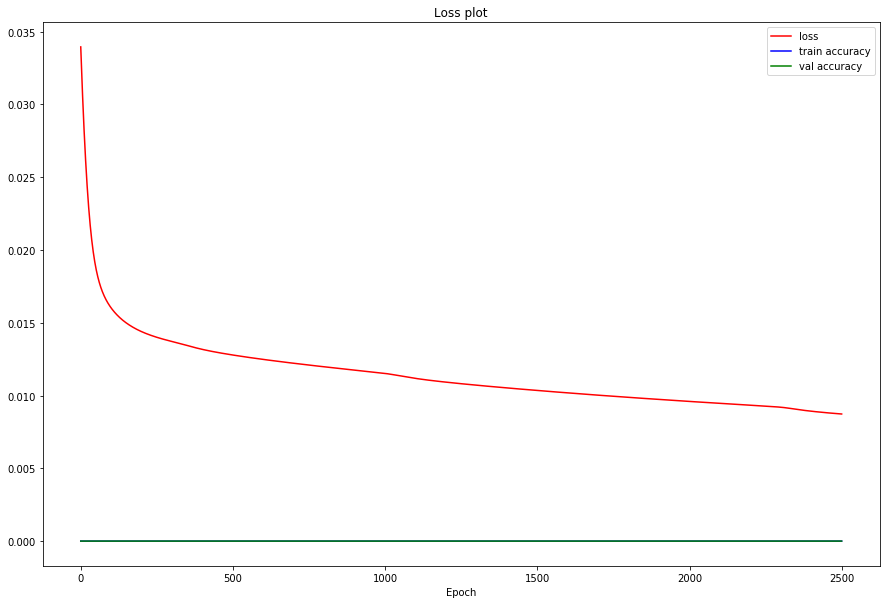

Training Loss before/after: 0.03395034745335579, 0.008731135167181492
Training accuracy before/after: 0, 0
Validation accuracy before/after: 0, 0
Final loss: 0.008731135167181492
Time taken: 428.4498357772827


In [11]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device)

# Define optimizer 
opt = optim.SGD(model.parameters(), lr=lr)
# opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

## Post-training Processing

### Save the model

Save the neural network weights and biases.

In [12]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "PitchShiftNN_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_input, n_hid, n_output, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
output.weight 	 torch.Size([513, 1026])
output.bias 	 torch.Size([513])
Model saved at model_data\PitchShiftNN_0.2_2500_1026_513_513_0.008731135167181492.pt


In [13]:
def create_testing_dataset(input_idx, output_idx):
    """ 
    Creates X, Y given the input_idx, output_idx.

    Requires all_spectrograms to be first created outside this method.

    Parameters: 
    input_idx (int): the flat idx of the original sample
    output_idx (int): the flat idx of the sample shifted by shift_amt

    Returns: 
    ndarray: X
    ndarray: Y
    """
    # Calculate shift amount based on input_idx and output_idx
    _,a,_ = nd_ref_idx(input_idx)
    _,b,_ = nd_ref_idx(output_idx)
    shift_amt = b-a
    
    # Generate pitched spectra
    _, one_pitched_spectra = resample_pitch_shift(np.array([all_wav_data[input_idx]]), shift_amt, overlap, n_ffts=1024)
    pitched_spectra = one_pitched_spectra[0].T
    
    # Generate X, Y
    X = np.hstack((all_spectrograms[input_idx].T, pitched_spectra))
    Y = all_spectrograms[output_idx].T
    
    # Ignore phase information
    X = np.absolute(X)
    Y = np.absolute(Y)
    
    return X, Y

### Create a test item for a single vowel

In [14]:
input_idx = list_of_test_idx[0][0]
output_idx = list_of_test_idx[0][1]

# print(list_of_test_idx)
# input_idx = 0
# output_idx = 0

X, Y = create_testing_dataset(input_idx, output_idx)

print(X.shape)
print(Y.shape)

(115, 1026)
(115, 513)


In [15]:
# Data normalization (option 1: by row)
# X, X_scale = normalize_rows(X, NormMode.NONNEG_TO_ZERO_ONE)
# Y, Y_scale = normalize_rows(Y, NormMode.NONNEG_TO_ZERO_ONE)

# print(np.amax(X), X_scale)
# print(np.amax(Y), Y_scale)

1.0 [0.01862215 0.01819624 0.01727765 0.01655696 0.0165674  0.01674316
 0.01819764 0.01851347 0.01768584 0.01755966 0.01797224 0.01685189
 0.01747949 0.01816973 0.01928513 0.02072753 0.01989388 0.0193521
 0.01838284 0.01742988 0.01741873 0.01547131 0.01457805 0.01421062
 0.01343173 0.01319908 0.01300045 0.01254896 0.01255563 0.01245773
 0.0128476  0.01336782 0.01370996 0.01423669 0.01432743 0.01480362
 0.01520081 0.01486157 0.01520045 0.01502427 0.01468089 0.01495349
 0.01508084 0.01514298 0.01464369 0.01401032 0.01442479 0.01450794
 0.01416903 0.01390212 0.0137449  0.01383586 0.01356364 0.01396743
 0.01446    0.01566763 0.01441625 0.01311344 0.01322071 0.01339229
 0.01304287 0.01304024 0.0126276  0.01162481 0.01176203 0.01218685
 0.01211765 0.01199854 0.01166711 0.01185372 0.01200925 0.01165263
 0.01183062 0.01199484 0.01190869 0.01193928 0.01172249 0.01175642
 0.01178918 0.01146037 0.01151758 0.01158803 0.011468   0.0113611
 0.01083714 0.01062628 0.01067751 0.01046352 0.0103617  0.01

In [16]:
# Data normalization (option 2: by array)
X_scale = np.amax(X)
X = X / X_scale

Y_scale = np.amax(Y)
Y = Y / Y_scale

print(np.amax(X), X_scale)
print(np.amax(Y), Y_scale)

In [17]:
# Create PyTorch tensor object from NumPy array
X = torch.Tensor(X)
X = X.float()

print(X)

tensor([[8.4685e-02, 1.4382e-02, 3.5038e-01,  ..., 3.9594e-04, 7.9255e-04,
         7.1743e-04],
        [6.2437e-03, 1.0452e-01, 3.8419e-01,  ..., 5.4818e-04, 8.2254e-04,
         8.1752e-05],
        [2.2210e-02, 1.1367e-01, 3.5835e-01,  ..., 7.1181e-04, 6.5064e-04,
         4.9615e-04],
        ...,
        [9.6944e-03, 4.1753e-02, 2.1359e-01,  ..., 2.0334e-04, 2.2249e-04,
         4.0219e-04],
        [2.7816e-03, 5.3058e-02, 2.2364e-01,  ..., 7.7539e-04, 8.8449e-04,
         3.0317e-04],
        [2.3000e-02, 6.0482e-02, 1.6710e-01,  ..., 1.5952e-03, 1.3715e-03,
         1.1197e-03]])


### Load the saved model

Load the saved model, and test the model on a single vowel.

In [18]:
model = PitchShiftNN(n_input = n_input, n_hid = n_hid, n_output = n_output)
model.load_state_dict(torch.load(model_path))
model.eval()

PitchShiftNN(
  (output): Linear(in_features=1026, out_features=513, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [19]:
X = X.to(device)
model.to(device)

# Generate prediction
Y_hat = model(X)

print(Y)
print(Y_hat)

[[8.46849382e-02 1.43820466e-02 3.50380301e-01 ... 3.95935407e-04
  7.92549923e-04 7.17437943e-04]
 [6.24366477e-03 1.04522593e-01 3.84189010e-01 ... 5.48191834e-04
  8.22545378e-04 8.17473701e-05]
 [2.22096257e-02 1.13673694e-01 3.58352333e-01 ... 7.11819506e-04
  6.50637376e-04 4.96141787e-04]
 ...
 [9.69444122e-03 4.17533852e-02 2.13594407e-01 ... 2.02694893e-04
  2.22120027e-04 4.02021949e-04]
 [2.78157182e-03 5.30582853e-02 2.23637328e-01 ... 1.38350733e-04
  2.71657889e-04 4.24816360e-04]
 [2.29996331e-02 6.04820214e-02 1.67096555e-01 ... 3.59755853e-04
  2.81886256e-04 5.45929128e-04]]
tensor([[0.0000, 0.0027, 0.1658,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0019, 0.1432,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0901,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0042, 0.1107,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0157, 0.1223,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0081, 0.1305,  ..., 0.0000, 0.0000, 0.0000]],
  

In [20]:
# Reconstruction using normalization option 1:

# # Create NumPy array from PyTorch tensor object
# Y_hat_np = Y_hat.cpu().detach().numpy()

# # Undo normalization
# Y_hat_renorm = np.array([ x / y for x,y in zip(Y_hat_np,Y_scale) ])
# Y_renorm = np.array([ x / y for x,y in zip(Y,Y_scale) ])

# print(Y_renorm.shape)
# print(Y_hat_renorm.shape)

(115, 513)
(115, 513)


In [21]:
# Reconstruction using normalization option 2:

# Create NumPy array from PyTorch tensor object
Y_hat_np = Y_hat.cpu().detach().numpy()

# Undo normalization
Y_hat_renorm = Y_hat_np * Y_scale
Y_renorm = Y * Y_scale

print(Y_hat_renorm.shape)
print(Y_renorm.shape)

## Recombine windows into waveform

Here, using the `griffinlim` algorithm, the post Fourier transform windows are recombined in order to reconstruct human singing sound.

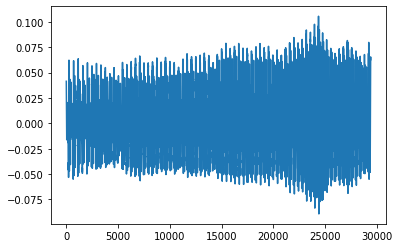

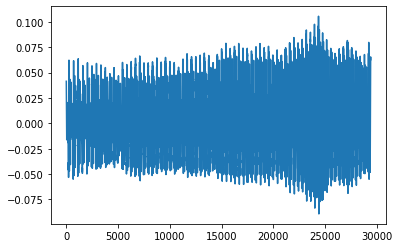

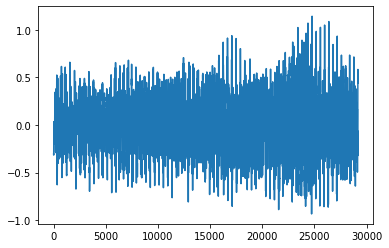

In [22]:
# The input track

waveform_original = all_wav_data[input_idx]
vowel_num,pitch_num,_ = nd_ref_idx(input_idx)
sio.wavfile.write('Input {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, waveform_original)

plt.figure()
plt.plot(waveform_original)

# The target track

waveform_target = all_wav_data[output_idx]
vowel_num,pitch_num,_ = nd_ref_idx(output_idx)
sio.wavfile.write('Target {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, waveform_target)

plt.figure()
plt.plot(waveform_target)

# The no-NN reconstruction of target track

gl_waveform_no_nn = librosa.griffinlim(np.transpose(Y_renorm), win_length=1024, hop_length=1024 // 4)
vowel_num,pitch_num,_ = nd_ref_idx(output_idx)
sio.wavfile.write('GL(Target) {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, gl_waveform_no_nn)

plt.figure()
plt.plot(gl_waveform_no_nn)

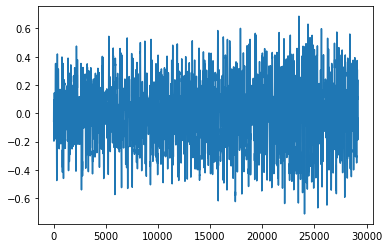

In [23]:
# The NN reconstruction of target track
gl_waveform = librosa.griffinlim(np.transpose(Y_hat_renorm), win_length=1024, hop_length=1024 // 4)
vowel_num,pitch_num,_ = nd_ref_idx(output_idx)
sio.wavfile.write('GL(Output) {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, gl_waveform)

plt.figure()
plt.plot(gl_waveform)

<Figure size 432x288 with 0 Axes>

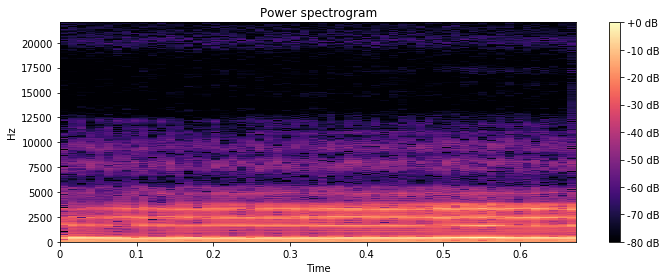

<Figure size 432x288 with 0 Axes>

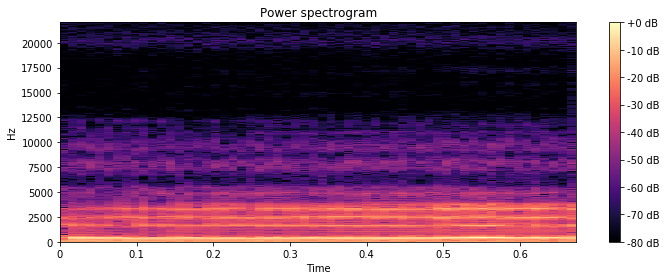

<Figure size 432x288 with 0 Axes>

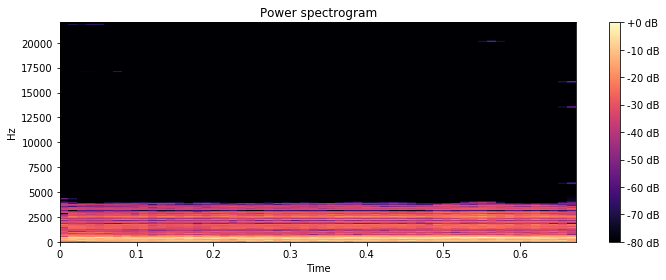

array([[ 4.3151119e-01+0.0000000e+00j, -5.5206828e-02+0.0000000e+00j,
         7.1012717e-01+0.0000000e+00j, ...,
         6.3269359e-01+0.0000000e+00j, -4.9712051e-02+0.0000000e+00j,
        -2.2049243e+00+0.0000000e+00j],
       [-1.5550960e+00+3.6342457e-16j,  6.4689517e-01+9.4018674e-01j,
         1.1031237e+00-3.5570439e-02j, ...,
         1.2624573e+00+2.3141593e-01j, -5.2579784e-01+3.6891615e+00j,
        -1.3521771e+00-3.0126307e-02j],
       [-7.3202109e+00+2.4769123e-16j,  1.6367998e+00+5.5943851e+00j,
         3.6937134e+00-1.5338733e+00j, ...,
        -1.4900746e+01+4.4358759e+00j,  4.1743723e-01-1.3712583e+01j,
         1.5326231e+01+2.5201976e-01j],
       ...,
       [ 1.4043738e-02+6.4558998e-17j, -1.4919710e-02-3.2466691e-02j,
         1.6186381e-02-2.3029241e-05j, ...,
        -4.5538303e-07+3.5896004e-08j, -2.1448696e-07+1.2363815e-07j,
        -8.3217066e-04+1.0213681e-05j],
       [ 3.2354859e-03-3.1311759e-16j,  3.4119242e-03+8.5768616e-03j,
        -2.4908443e-03

In [24]:
plt.figure()
stft(all_wav_data[output_idx])

plt.figure()
stft(gl_waveform_no_nn)

plt.figure()
stft(gl_waveform)